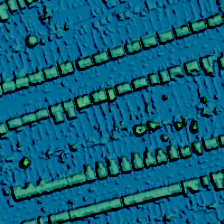

In [1]:
from IPython.display import Image
Image(filename='LIDAR/LIDAR_24974.png') 

In [2]:
# imports
import numpy as np
import pandas as pd
import h5py as h5py
import PIL

# Others
import numpy as np
from sklearn.model_selection import train_test_split

# For AUC estimation and ROC plots
from sklearn.metrics import roc_curve, auc

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Image and directories
#import cv2
import os

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow import keras

In [3]:
# read csv file
df = pd.read_csv("EmbeddingData_C3_9528.csv")

# add a path column to augment the absolute path of the image
df["path"] = [os.path.join("LIDAR/", "LIDAR_" + str(i) + '.png') for i in df.id.values]
df["path"][0]

'LIDAR/LIDAR_48552.png'

In [4]:
df.education.sort_values()

26191     0.013
22240     0.013
1856      0.013
18918     0.013
26750     0.013
          ...  
19555    57.186
18153    57.186
2999     58.976
26879    58.976
35423    58.976
Name: education, Length: 36723, dtype: float64

In [12]:
# create train and test split
train, test = train_test_split(df, 
                               test_size = 0.225,
                               random_state = 250918939)

# VGG16

In [4]:
# download vgg16 from Google
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16(weights = 'imagenet',      # The weights from the ImageNet competition
              include_top = False, # Do not include the top layer, should be linear.
              input_shape= (224, 224, 3) # Input shape. 
             )

In [5]:
# make sure that it's running on GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14522336666941575968
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4155965440
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8936798452371441430
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [7]:
# define my model

# Create new model
VGGModel = Sequential()

# Copy the layers to our new model. This needs to be done as there is a bug in Keras.
for layer in model.layers:
    VGGModel.add(layer)

# Set the layers as untrainable
for layer in VGGModel.layers:
    layer.trainable = False

# define the last two convolutional layers as trainable
VGGModel.layers[15].trainable=True
VGGModel.layers[16].trainable=True


# add head layers

# flatten outputs from max pooling (matrix) as inputs for dense layer (vector)
VGGModel.add(Flatten(input_shape=VGGModel.output_shape[1:]))

# define dense layers
VGGModel.add(Dense(128, activation="relu"))
VGGModel.add(Dropout(0.5))
VGGModel.add(Dense(128, activation = "relu"))
VGGModel.add(Dropout(0.5))
VGGModel.add(Dense(1, activation="relu")) # use relu since education always > 0

In [46]:
VGGModel.save('my_VGG16_empty')

INFO:tensorflow:Assets written to: my_VGG16_empty\assets


## train the model

In [28]:
# read model
VGGModel.load_weights('checkpoint2/VGGModel.78.391.h5')


In [33]:
# compiling the model
import tensorflow.keras as keras
VGGModel.compile(loss="mean_squared_error", 
                 optimizer=optimizers.Adam(learning_rate=0.00001, decay=0.001/200),
                 metrics=[keras.metrics.mean_squared_error])

In [15]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    shear_range = 0,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale = 1/255,
    shear_range = 0,
    zoom_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=preprocess_input,
)

# define batch_size (tryout different sizes, got a K80)
batch_size = 128

# point to the data directory
data_dir = "LIDAR"

# image size
(img_height, img_width) = (224, 224)

data_dir

'LIDAR'

In [16]:
# generate batches for training
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train,
    directory = '.',
    x_col = "path",
    y_col = "education",
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "raw",
    subset = "training",
    shuffle = True,
    interpolation='bilinear'
)

# generate batches for validation
validation_generator = train_datagen.flow_from_dataframe(
    dataframe = train,
    directory = '.',
    x_col = "path",
    y_col = "education",
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "raw",
    subset = "validation",
    shuffle = True,
    interpolation='bilinear'
)

# generate batches for testing
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory='.',
    x_col='path',
    y_col='education',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    class_mode='raw',
    interpolation='bilinear'
)



Found 22768 validated image filenames.
Found 5692 validated image filenames.
Found 8263 validated image filenames.


In [51]:
# setup callback
checkpoint_path = 'checkpoint2/VGGModel.{val_loss:.3f}.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# define a exponentially declining learning rate
def scheduler(epoch,lr):
    if epoch<2:
        return lr
    else:
        return lr * tf.math.exp(-0.15)

my_callback = [
    # save the weights of the best performing model to the checkpoint folder
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                      save_best_only=True,
                      save_weights_only=True),
    # strop training when validation error stays within 0.0001 for 8 rounds
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                      min_delta = 0.0001,
                      patience=10),
    # training with a declining learning rate
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)
]

In [52]:

epochs = 20

# Train!!!!!!!!!!!!!!!!!!!!!!!
VGGModel.fit(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    steps_per_epoch = 178,
    validation_steps = 45,
    callbacks = my_callback
)

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1.3533515357266879e-06.
178/178 [==============================] - 305s 2s/step - loss: 75.1998 - mean_squared_error: 75.1998 - val_loss: 71.4680 - val_mean_squared_error: 71.4680
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 1.3533515357266879e-06.
178/178 [==============================] - 302s 2s/step - loss: 75.1147 - mean_squared_error: 75.1147 - val_loss: 71.4685 - val_mean_squared_error: 71.4685
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(1.1648405e-06, shape=(), dtype=float32).
178/178 [==============================] - 301s 2s/step - loss: 74.4771 - mean_squared_error: 74.4771 - val_loss: 71.7228 - val_mean_squared_error: 71.7228
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(1.0025874e-06, shape=(), dtype=float32).
178/178 [==============================] - 302s 2s/step - loss: 74.6896 - mean_squared_err

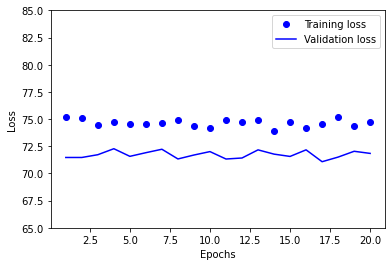

In [55]:
# check performance
loss = VGGModel.history.history['loss']
val_loss = VGGModel.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim([65,85])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [54]:
# save model the model
#VGGModel.save('my_VGG16_2')

INFO:tensorflow:Assets written to: my_VGG16_2\assets


## test performance

In [17]:
# define the loss function (mse)
def mean_squared_loss(ytrue,ypred):
    ytrue, ypred = np.array(ytrue), np.array(ypred)
    return np.mean((ytrue-ypred)**2)

In [18]:
# assess the performance

# model with validation loss of 76.523
#VGGModel=keras.models.load_model('my_VGG16')
#VGGModel.load_weights('checkpoint2/VGGModel.71.079.h5')
test_generator.reset()
prediction = VGGModel.predict(test_generator)
print()
prediction = prediction.reshape(-1)
mse = mean_squared_loss(test_generator.labels,prediction)
print("The mean squared error of prediction is %.3f" % (mse))

The mean squared error of prediction is 71.768


# GradCAM

In [9]:
# load weight of best model
VGGModel=keras.models.load_model('my_VGG16')
VGGModel.load_weights("checkpoint2/VGGModel.71.003.h5")

In [4]:
# imports
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [5]:
# define the function to get img array
def get_img_array(img_path):
    size = (224,224)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
  # add a dimension to become (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    array = preprocess_input(array)
    return array

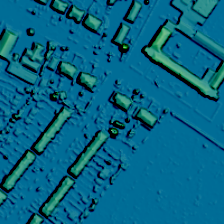

In [6]:
# get an image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
img_path = 'LIDAR/LIDAR_46315.png'
id = 46315
data = get_img_array(img_path)

display(Image(img_path))

In [7]:
# define the heatmap
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    from tensorflow import keras
    import tensorflow as tf
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [10]:
# print predicted education deprivation
ypred = VGGModel.predict(preprocess_input(data/255))
ypred = ypred.reshape(-1)
print("prediction: ", ypred[0])
print("actual value: ",5.411)

prediction:  7.591782
actual value:  5.411


In [12]:
# set layers
last_conv_layer_name = "block5_conv3"
classifier_layer_names = ["block5_pool","flatten","dense","dense_1","dense_2"]

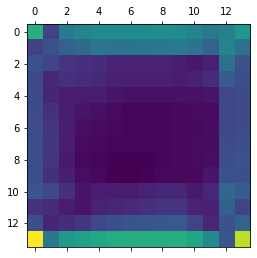

In [13]:
# plot the heatmap
heatmap = make_gradcam_heatmap(preprocess_input(data/255),VGGModel,last_conv_layer_name,classifier_layer_names)

plt.matshow(heatmap)
plt.show()

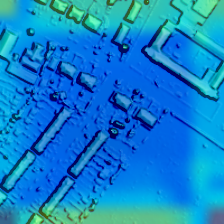

In [14]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = str(id) + ".png"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))


# Examine the data

In [35]:
df.education.describe()

count    36723.000000
mean        12.995546
std         10.240666
min          0.013000
25%          4.481000
50%         10.925000
75%         19.086000
max         58.976000
Name: education, dtype: float64

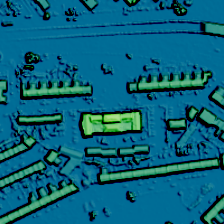

prediction:  8.432961
actual value:  24.626
